In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import joblib
import json
import os

import sys
sys.path.append("../utils")

from utils import load_csv

In [34]:
features = [
    "open", "high", "low", "close", "volume",
    "EMA_9", "SMA_5", "SMA_10", "SMA_15", "SMA_30", "RSI_14", "MACD"]  
target = 'close'


In [35]:
def train_xgb_for_stock(symbol: str, features: list, target: str = 'close'):
    data_path = f"../../data/features/{symbol}_features.csv"
    df = load_csv(data_path)

    # Lấy tập huấn luyện
    X = df[features]
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )

    model = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.05,
        max_depth=8,
        gamma=0.02,
        random_state=42
    )

    model.fit(X_train, y_train)

    # Dự đoán
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Tính các chỉ số đánh giá
    mae = mean_absolute_error(y_test, y_test_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
    r2 = r2_score(y_test, y_test_pred)

    print(f"=== Đánh giá mô hình cho {symbol.upper()} ===")
    print(f"MAE:  {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}")
    print(f"R²:   {r2:.2f}")

    metrics = {
    "MAE": round(mae, 4),
    "RMSE": round(rmse, 4),
    "MAPE (%)": round(mape, 4),
    "R2": round(r2, 4)
    }

    with open(f"../../output/metrics/xgb_{symbol}_metrics.json", "w", encoding="utf-8") as f:
        json.dump(metrics, f, indent=4)


    # Khởi tạo mảng trống để giữ giá trị dự đoán cùng độ dài với toàn bộ dữ liệu
    train_pred_plot = np.empty_like(df[target])
    train_pred_plot[:] = np.nan
    train_pred_plot[:len(y_train_pred)] = y_train_pred

    test_pred_plot = np.empty_like(df[target])
    test_pred_plot[:] = np.nan
    test_pred_plot[len(y_train_pred):] = y_test_pred

    # Vẽ biểu đồ toàn bộ
    plt.figure(figsize=(16, 5))
    plt.plot(df[target].values, label='Original Data', color='blue')
    plt.plot(train_pred_plot, label='Train Predict', color='green')
    plt.plot(test_pred_plot, label='Test Predict', color='red')
    plt.title(f"{symbol.upper()} Stock Price Prediction")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Biểu đồ phân phối residual
    residuals = y_test - y_test_pred

    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=50, color='blue', alpha=0.7)
    plt.title(f"Residual Distribution for {symbol.upper()}")
    plt.xlabel("Residual")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # Lưu mô hình
    model_dir = "../../model/"
    os.makedirs(model_dir, exist_ok=True)

    model_path = os.path.join(model_dir, f"{symbol}_xgb_model.pkl")
    joblib.dump(model, model_path)
    print(f"✅ Đã lưu mô hình vào: {model_path}")

2025-06-30 06:44:01,132 - INFO - ✅ Load CSV thành công: ../../data/features/fpt_features.csv | shape = (4587, 13)


=== Đánh giá mô hình cho FPT ===
MAE:  29.07
RMSE: 42.84
MAPE: 26.26
R²:   -0.82


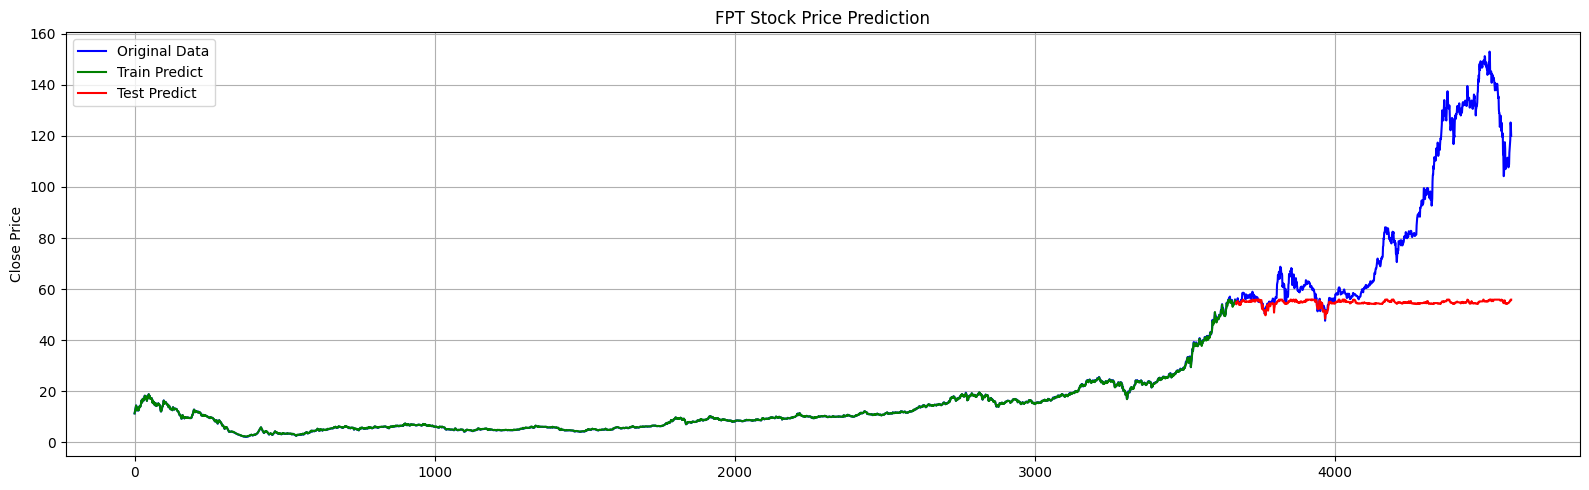

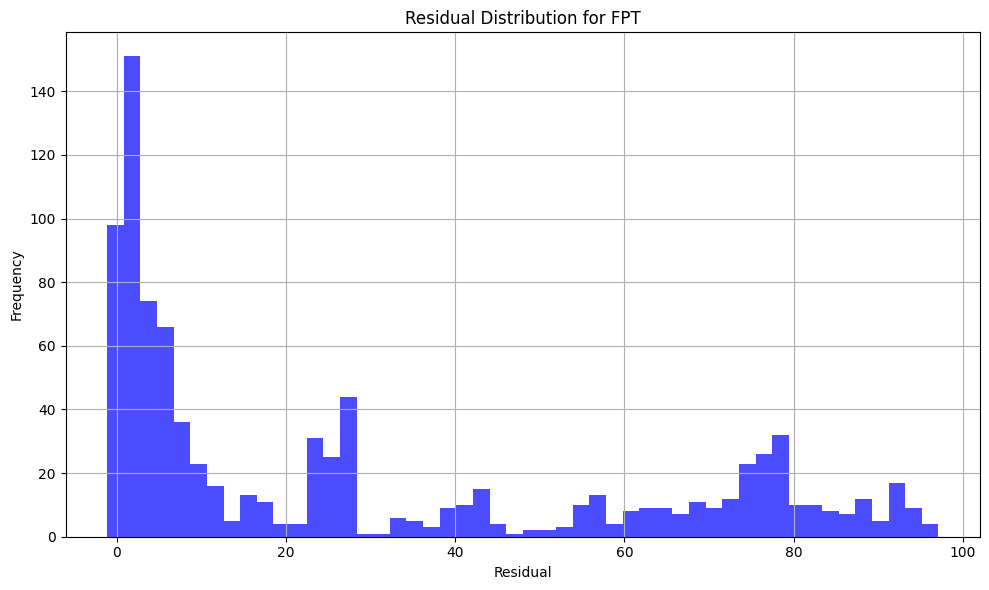

2025-06-30 06:44:01,762 - INFO - ✅ Load CSV thành công: ../../data/features/vnm_features.csv | shape = (4813, 13)


✅ Đã lưu mô hình vào: ../../model/fpt_xgb_model.pkl
=== Đánh giá mô hình cho VNM ===
MAE:  0.30
RMSE: 0.39
MAPE: 0.48
R²:   0.99


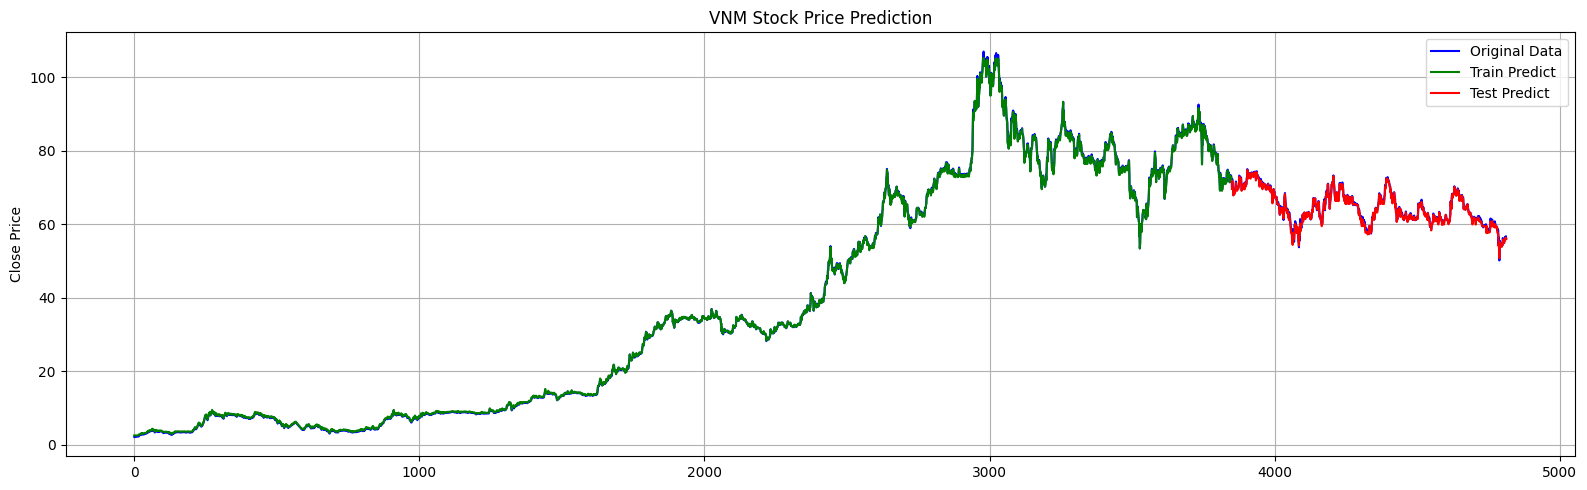

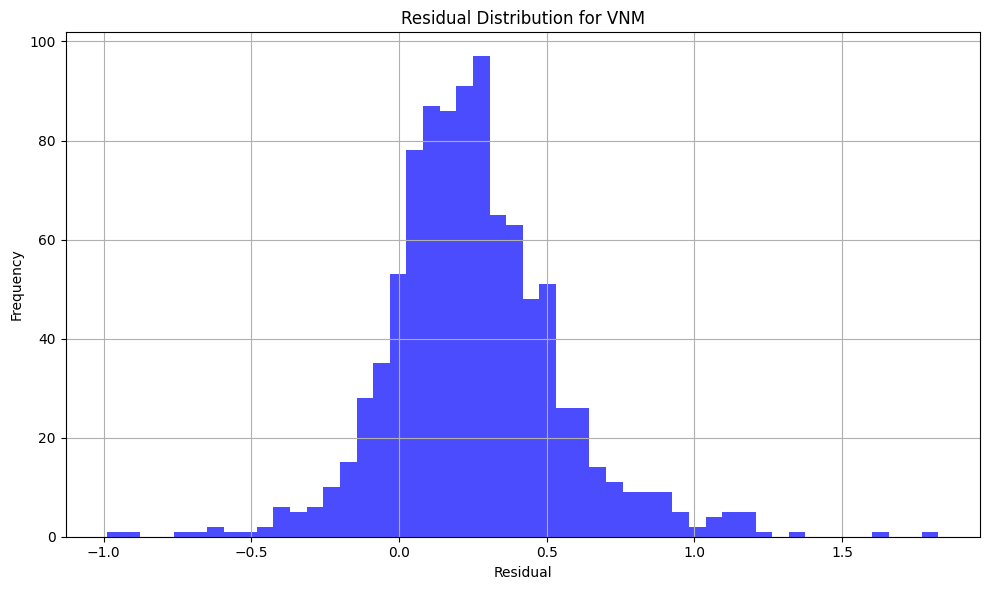

2025-06-30 06:44:02,293 - INFO - ✅ Load CSV thành công: ../../data/features/hpg_features.csv | shape = (4358, 13)


✅ Đã lưu mô hình vào: ../../model/vnm_xgb_model.pkl
=== Đánh giá mô hình cho HPG ===
MAE:  0.48
RMSE: 0.63
MAPE: 2.29
R²:   0.97


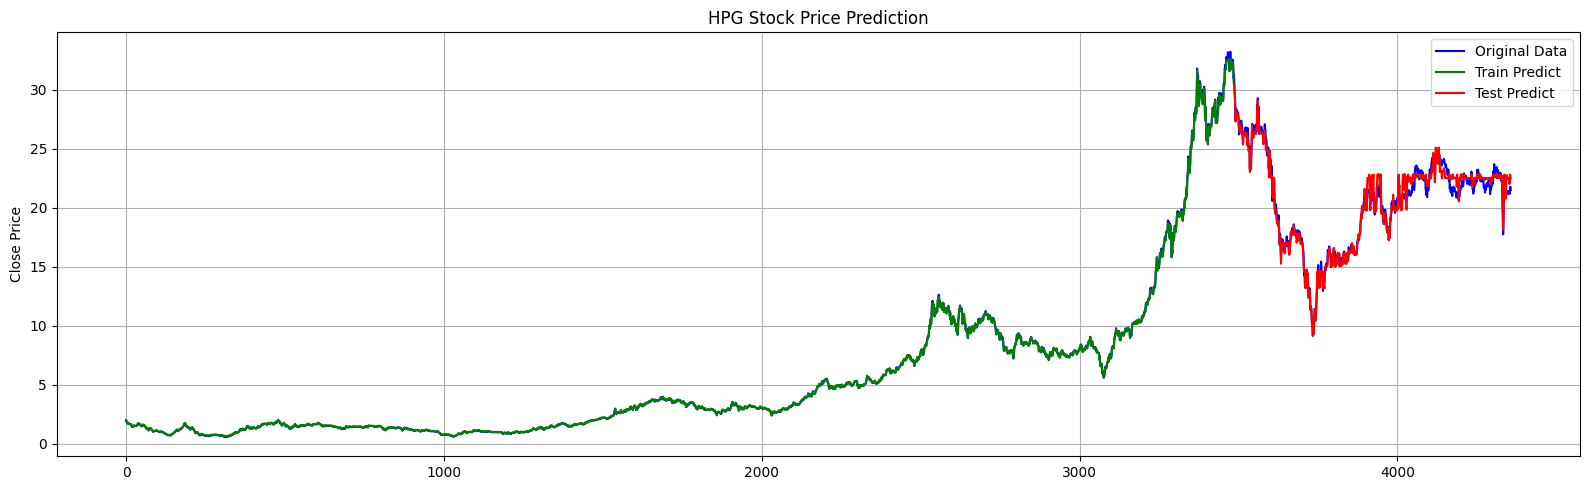

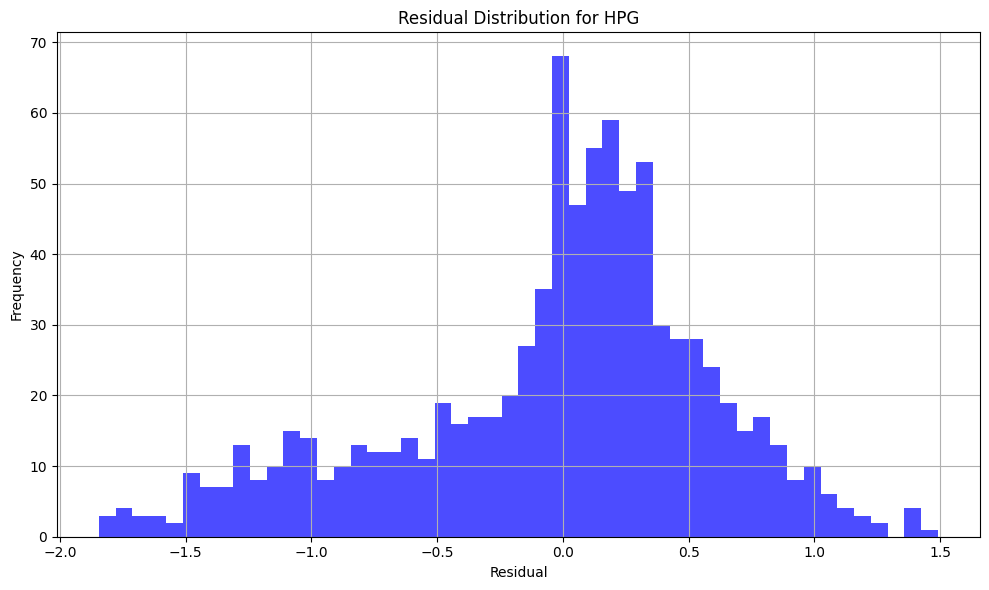

✅ Đã lưu mô hình vào: ../../model/hpg_xgb_model.pkl


In [36]:
symbols = ["fpt", "vnm", "hpg"]
for symbol in symbols:
    train_xgb_for_stock(symbol, features)
